In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import nivapy
import networkx as nx
import imp
import seaborn as sn
import glob
import os
from collections import defaultdict 
from branca.colormap import linear

sn.set_context('notebook')

# NOPE metals

Initial ideas for developing a new metals module for NOPE.

In [2]:
# Connect to db
engine = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


In [3]:
# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')
rid = imp.load_source('useful_rid_code', rid_func_path)

## 1. Existing method

For the RID programme, in unmonitored areas we currently estimate loads of metals by summing all the point inputs and assuming they make it to the coast. In other words, we ignore catchment retention and any diffuse inputs. The aim of this notebook is to develop an approach that is more rigorous, but as a starting point it would be good to know how well the existing method actually works. The new method should obviously be demonstrably better than what we have already.

### 1.1. Observed loads for 155 sites

Since 1990, the RID programme has gathered a lot of observed data for the 155 monitored rivers. We can use this to test how well summing the point inputs works for metals. This might also provide some clues regarding which aspects of the model should be improved first.

The code below extracts observed metals data for the 155 RID stations where measurements are available. 

In [4]:
# Read station data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Data\RID_Sites_List.xlsx')
stn_df = pd.read_excel(in_xlsx, sheetname='RID_All')

# Period of interest
st_yr, end_yr = 1990, 2016

# Pars of interest
par_list = ['Ag', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'Hg']

In [5]:
#%%capture
#
## Container for results 
#loads_list = []
#
## Loop over sites
#for stn_id in stn_df['station_id'].values:
#    # Loop over years
#    for year in range(st_yr, end_yr+1):
#        print 'Processing Station ID %s for %s' % (stn_id, year)
#        
#        # Get loads
#        l_df = rid.estimate_loads(stn_id, par_list, 
#                                  year, engine,
#                                  infer_missing=False)
#        
#        if l_df is not None:
#            # Name and reset index
#            l_df.index.name = 'station_id'
#            l_df.reset_index(inplace=True)
#
#            # Add year
#            l_df['year'] = year
#
#            # Add to outout
#            loads_list.append(l_df)
#
## Concatenate to new df
#lds_ts = pd.concat(loads_list, axis=0)
#
## Build multi-index
#lds_ts.set_index(['station_id', 'year'], inplace=True)
#
## Save output
#out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
#           r'\NOPE\Metals\obs_metals_155_%s-%s.csv' % (st_yr, end_yr))
#lds_ts.to_csv(out_csv)

In [6]:
# Avoids re-running the above cell, which is slow

# Read obs data
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\Metals\obs_metals_155_1990-2016.csv')
obs_df = pd.read_csv(in_csv)

# Convery Hg to tonnes and remove units
obs_df.set_index(['station_id', 'year'], inplace=True)
obs_df['Hg_kg'] = obs_df['Hg_kg']/1000
obs_df.columns = [i.split('_')[0] for i in obs_df.columns]
obs_df.reset_index(inplace=True)

# Ignore Ag as no point data
del obs_df['Ag']

obs_df.head()

,station_id,year,As,Cd,Cr,Cu,Hg,Ni,Pb,Zn
0,29615,1990,NaN,0.228425,NaN,6.191198,0.002654,NaN,2.245350,23.761415
1,29615,1991,NaN,0.100417,NaN,5.235714,0.003963,NaN,2.361637,29.034573
2,29615,1992,NaN,0.627963,2.777596,9.217833,0.010250,1.003670,2.483236,20.509088
3,29615,1993,0.719119,0.234133,2.139408,38.853526,0.006583,2.293064,4.769157,147.432082
4,29615,1994,NaN,0.177071,NaN,3.982295,0.017002,NaN,2.132331,23.101107


### 1.2. Sum point inputs for 155 sites

The code below builds a simplified NOPE network and uses it to accumulate point metal discharges.

In [7]:
# Build "empty" network
net_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Core_Input_Data\regine.csv')
net_df = pd.read_csv(net_csv, sep=';')
net_df = net_df[['regine', 'regine_ned']]

# Build graph
g = nx.DiGraph()

# Add nodes
for idx, row in net_df.iterrows():
    nd = row['regine']
    g.add_node(nd, local={}, accum={})

# Add edges
for idx, row in net_df.iterrows():
    fr_nd = row['regine']
    to_nd = row['regine_ned']
    g.add_edge(fr_nd, to_nd)

# Check directed tree
assert nx.is_tree(g), 'g is not a valid tree.'
assert nx.is_directed_acyclic_graph(g), 'g is not a valid DAG.' 

In [8]:
# Container for results
data_dict = defaultdict(list)

# Loop over years
for year in range(st_yr, end_yr+1):
    # Group point metal inputs by regine 
    sql = ("SELECT a.regine, "
           "  b.name, "
           "  b.unit, "
           "  SUM(c.value * d.factor) as value "
           "FROM RESA2.RID_PUNKTKILDER a, "
           "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
           "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
           "RESA2.RID_PUNKTKILDER_INP_OUTP d "
           "WHERE a.anlegg_nr = c.anlegg_nr "
           "AND d.in_pid = c.inp_par_id "
           "AND d.out_pid = b.out_pid "
           "AND c.year = %s "
           "GROUP BY a.regine, b.name, b.unit "
           "ORDER BY a.regine" % year)
    df = pd.read_sql(sql, engine)
    
    # Get cols of interest
    df = df[df['name'].isin(par_list)]

    # Tidy
    df['par'] = df['name'] + '_' + df['unit']
    del df['name'], df['unit']

    # Pivot
    df = df.pivot(index='regine', columns='par', values='value')
    df.reset_index(inplace=True)
    
    # Join to network data and tidy
    df = pd.merge(net_df, df, how='left', on='regine')
    df.fillna(0, inplace=True)
    df.index = df['regine']
    del df['regine'], df['regine_ned']
    
    # Update network properties
    for idx, row in df.iterrows():
        g.node[idx]['local'] = row.to_dict()
    
    # Accumulate downstream
    # Process nodes in topo order from headwaters down
    for nd in nx.topological_sort(g)[:-1]:
        # Get catchments directly upstream
        preds = g.predecessors(nd)

        if len(preds) > 0:
            # Accumulate total input from upstream
            tot_dict = defaultdict(int) # Defaults to 0

            # Loop over upstream catchments            
            for pred in preds:                
                # Loop over quantities of interest
                for col in df.columns:
                    tot_dict[col] += g.node[pred]['accum'][col]              

            # Assign outputs  
            for col in df.columns:
                g.node[nd]['accum'][col] = g.node[nd]['local'][col] + tot_dict[col]

        else:
            # No upstream inputs
            for col in df.columns:
                g.node[nd]['accum'][col] = g.node[nd]['local'][col]
    
    # Get accumulated loads for RID-155 rivers    
    for idx, row in stn_df.iterrows():
        data_dict['station_id'].append(row['station_id'])
        data_dict['year'].append(year)
        for col in df.columns:
            data_dict[col].append(g.node[row['nve_vassdrag_nr']]['accum'][col])

# Build df
mod_df = pd.DataFrame(data_dict)

# Reorder cols and remove units
mod_df.set_index(['station_id', 'year'], inplace=True)
mod_df.columns = [i.split('_')[0] for i in mod_df.columns]
mod_df.reset_index(inplace=True)

mod_df.head()

,station_id,year,As,Cd,Cr,Cu,Hg,Ni,Pb,Zn
0,29615,1990,0.0,0.0,0.0,0.001,0.0,0.004,0.0,0.002
1,29821,1990,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
2,29783,1990,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
3,29613,1990,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000
4,29614,1990,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000


### 1.3. Compare observed fluxes to aggregated point inputs

In [9]:
# Join mod and obs
df = pd.merge(obs_df, mod_df, how='left', on=['station_id', 'year'],
              suffixes=['_obs', '_mod'])

df.head()

,station_id,year,As_obs,Cd_obs,Cr_obs,Cu_obs,Hg_obs,Ni_obs,Pb_obs,Zn_obs,As_mod,Cd_mod,Cr_mod,Cu_mod,Hg_mod,Ni_mod,Pb_mod,Zn_mod
0,29615,1990,NaN,0.228425,NaN,6.191198,0.002654,NaN,2.245350,23.761415,0.0,0.0000,0.0,0.001000,0.0,0.004000,0.0,0.002000
1,29615,1991,NaN,0.100417,NaN,5.235714,0.003963,NaN,2.361637,29.034573,0.0,0.0004,0.0,0.007000,0.0,0.014000,0.0,0.000000
2,29615,1992,NaN,0.627963,2.777596,9.217833,0.010250,1.003670,2.483236,20.509088,0.0,0.0000,0.0,0.000010,0.0,0.008173,0.0,0.000005
3,29615,1993,0.719119,0.234133,2.139408,38.853526,0.006583,2.293064,4.769157,147.432082,0.0,0.0000,0.0,0.000149,0.0,0.000124,0.0,0.000031
4,29615,1994,NaN,0.177071,NaN,3.982295,0.017002,NaN,2.132331,23.101107,0.0,0.0000,0.0,0.000520,0.0,0.000636,0.0,0.000001


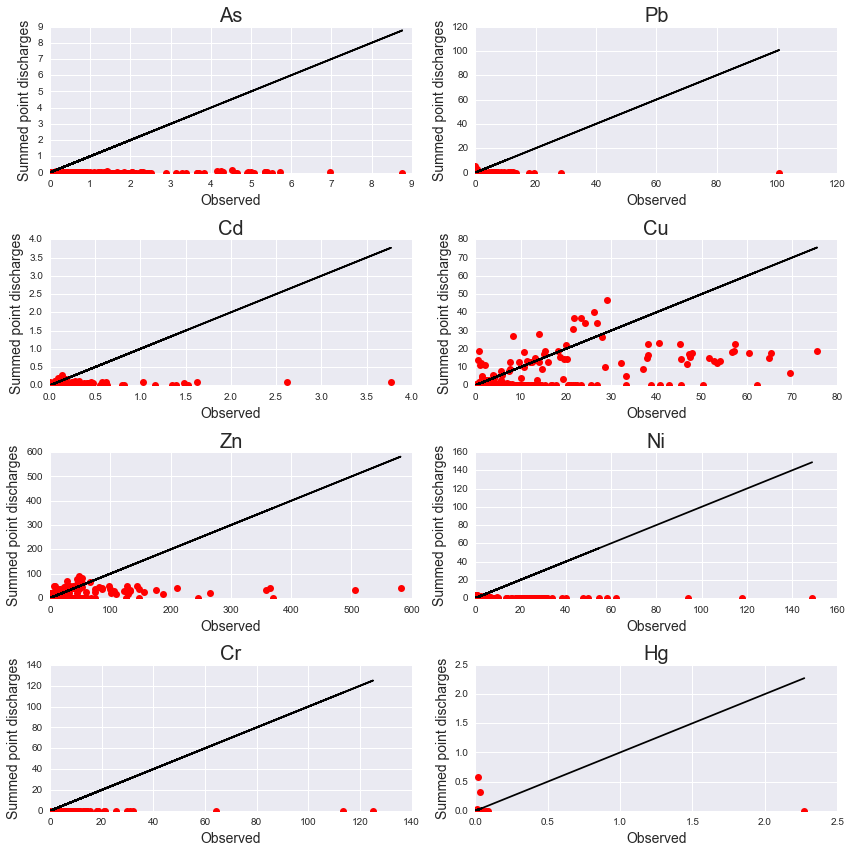

In [10]:
# Pars of interest (ignore Ag)
par_list = ['As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'Hg']

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for idx, col in enumerate(par_list):
    axes[idx].plot(df['%s_obs' % col], df['%s_mod' % col], 'ro')
    axes[idx].plot(df['%s_obs' % col], df['%s_obs' % col], 'k-')
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel('Observed', fontsize=14)
    axes[idx].set_ylabel('Summed point discharges', fontsize=14)

plt.tight_layout()
plt.show()

It is clear from this plot that the existing approach does not work very well. At least there is plenty of scope for improvement! 

However, following a bit of experimentation, one interesting feature of the above dataset is that **summing point discharges seems to work OK for Cd, Cu and Zn for station ID 29778 (STREORK/Orkla)** - see the plot below.

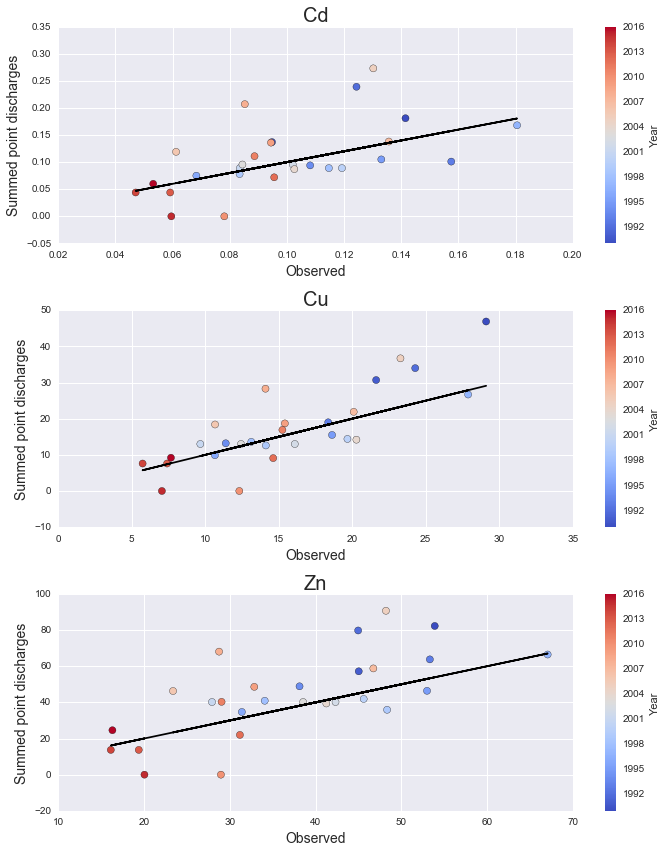

In [11]:
# Plot just 29778
ork_df = df.query('station_id == 29778')

# Pars of interest (ignore Ag)
par_list = ['Cd', 'Cu', 'Zn']

# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
axes = axes.flatten()

for idx, col in enumerate(par_list):
    sc = axes[idx].scatter(ork_df['%s_obs' % col], ork_df['%s_mod' % col],
                           c=ork_df['year'], vmin=st_yr, vmax=end_yr, 
                           cmap='coolwarm', s=50)
    axes[idx].plot(ork_df['%s_obs' % col], ork_df['%s_obs' % col], 'k-')
    fig.colorbar(sc, ax=axes[idx], label='Year')
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel('Observed', fontsize=14)
    axes[idx].set_ylabel('Summed point discharges', fontsize=14)

plt.tight_layout()
plt.show()

The relationship is far from perfect, but there's a clear positive correlation between observed loads and summed point discharges at this one site. It would be interesting to know why the approach works here, but not elsewhere. Presumably there is a major point source of Cd, Cu and Zn somewhere near our monitoring station?

As a check, create a map showing the Orkla montioring site and all nearby point sources reporting Zn discharges.

In [12]:
# Read 2016 Zn data
sql = ("SELECT a.lat_utl AS latitude, "
       "  a.lon_utl AS longitude, "
       "  a.anlegg_navn AS station_name, "
       "  a.anlegg_nr AS station_code, "
       "  (c.value * d.factor) AS value "
       "FROM RESA2.RID_PUNKTKILDER a, "
       "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
       "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
       "RESA2.RID_PUNKTKILDER_INP_OUTP d "
       "WHERE a.anlegg_nr = c.anlegg_nr "
       "AND d.in_pid = c.inp_par_id "
       "AND d.out_pid = b.out_pid "
       "AND c.year = 2016 "
       "AND b.name = 'Zn'")
zn_df = pd.read_sql(sql, engine)

# Decode special characters
for col in zn_df.columns:
    if zn_df[col].dtype == object:
        zn_df[col] = zn_df[col].str.decode('windows-1252')
        
# Map of point discharges and monitoring station at stn 29778
ork_stn = stn_df.query('station_id == 29778')

map1 = nivapy.spatial.quickmap(zn_df)
map1 = nivapy.spatial.quickmap(ork_stn, lon_col='lon', lat_col='lat', 
                               map_obj=map1)
map1

Zooming in on this map, we see that the site `Løkken Gruber (1636.0010.01)` is just upstream of the monitoring station. Let's see what this station reported in 2016.

In [13]:
# Read 2016 data for Løkken Gruber
sql = ("SELECT a.anlegg_navn, "
       "  a.anlegg_nr, "
       "  a.type, "
       "  b.name, "
       "  b.unit, "
       "  (c.value * d.factor) AS value "
       "FROM RESA2.RID_PUNKTKILDER a, "
       "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
       "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
       "RESA2.RID_PUNKTKILDER_INP_OUTP d "
       "WHERE a.anlegg_nr = c.anlegg_nr "
       "AND d.in_pid = c.inp_par_id "
       "AND d.out_pid = b.out_pid "
       "AND c.year = 2016 "
       "AND a.anlegg_nr = '1636.0010.01'")
pt_df = pd.read_sql(sql, engine)

# Decode special characters
for col in pt_df.columns:
    if pt_df[col].dtype == object:
        pt_df[col] = pt_df[col].str.decode('windows-1252')
        
pt_df

,anlegg_navn,anlegg_nr,type,name,unit,value
0,Løkken Gruber,1636.0010.01,INDUSTRI,Cd,tonn,0.06
1,Løkken Gruber,1636.0010.01,INDUSTRI,Cu,tonn,9.20
2,Løkken Gruber,1636.0010.01,INDUSTRI,Zn,tonn,24.60


OK, so it's pretty clear that Løkken Gruber is a major source of Cd, Cu and Zn, which makes sense. In fact, a quick Google shows that Løkken Gruber is an old copper mining region with some serious pollution potential - Miljødirektoratet even have a [dedicated website](http://www.miljostatus.no/lokken-gruber) describing the issues and its impacts on the Orkla. 

Overall, this is a good sign that our data actually make sense, although it would be interesting to know how Miljødirektoratet assess the "point discharges" from this location. If it's an old mine then the pollutiuon is likely to be "semi-diffuse", in which case Miljødirektoratet might just monitor concentrations downstream of the site and use these to estimate loads. If this is true, then what what the plots above really show is just how hard it is to consistently estimate river fluxes.

### 1.4. Summary of existing approach

In general, **summing point discharges works poorly as a way of estimating metal discharges to the coast**. However, for at least one location (STREORK/Orkla), it works OK, because we have a major mining plant (Løkken Gruber) located directly upsteram of the monitoring station. In this case, there is a clear positive relationship between recorded point discharges and monitored loads. This implies that, **in cases where point sources of metals dominate, our data are good enough to pick this up**. However, it's pretty clear that other sources (presumably diffuse?) dominate in the vast majority of Norwegian catchments.

So, we need to consider diffuse inputs...

## 2. Atmospheric deposition

Good quality atmospheric deposition data for metals seems to be difficult to find. I have e-mailed Wenche Aas at NILU to ask what datasets are available, but for metals it seems information is limited (see e-mail from Wenche received 08/11/2017 at 10:44). The best data I can find come from the [Meteorological Synthesizing Centre-East](http://www.msceast.org/index.php/pollution-assessment/emep-domain-menu/data-hm-pop-menu), which is part of EMEP. They have modelled deposition data for Cd, Hg and Pb for Norway for the years 2014 and 2015. Data are provided on a 50 km EMEP grid and are saved locally here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals\Raw_Datasets\EMEP

Based on this data, I can estimate atmospheric inputs of Cd, Hg and Pb to each regine catchment. This can be added to the point source data (section 1.2, above) and compared to the observations to see if the fit to the observed data improves.

### 2.1. Explore MSC-E data

In [14]:
# Read EMEP shapefile
in_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\NOPE\Metals'
          r'\Raw_Datasets\EMEP\reprojected_emep_grid_50\emep_scandinavia.shp')
gdf = gpd.read_file(in_shp)

# Get cols of interest
gdf = gdf[['geometry', 'i50', 'j50']]

# Read MSC-E dep data
# Files to read
dep_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\EMEP')
search_path = os.path.join(dep_fold, '*.txt')
file_list = glob.glob(search_path)
df_list = []

# Loop over files
for fpath in file_list:
    # Get info
    par, _, year = os.path.split(fpath)[1].split('_')
    year = year[:4]
    dep_df = pd.read_csv(fpath, delim_whitespace=True, skiprows=1, 
                         header=None, names=['i50', 'j50', '%s_%s' % (par, year)])
    
    # Set i_j as idx
    dep_df['i_j'] = dep_df['i50'].map(str) + '_' + dep_df['j50'].map(str)
    dep_df.index = dep_df['i_j']
    del dep_df['i_j'], dep_df['i50'], dep_df['j50']
    
    # Add to output
    df_list.append(dep_df)
    
# Merge and tidy
dep_df = pd.concat(df_list, axis=1)
dep_df.reset_index(inplace=True)
dep_df['i50'], dep_df['j50'] = [i.astype(int) for i in dep_df['i_j'].str.split('_', 1).str]
del dep_df['i_j']

# Join spatial info
gdf = gdf.merge(dep_df, on=['i50', 'j50'], how='inner')

# Convert crs to UTM Z33
gdf = gdf.to_crs(epsg='32633')

# Save
out_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\Raw_Datasets\EMEP\msc-e_atmos_dep_utm_z33n.shp')
gdf.to_file(out_shp)

gdf.head()

,geometry,i50,j50,cd_2014,cd_2015,hg_2014,hg_2015,pb_2014,pb_2015
0,"POLYGON ((837779.4393681677 7946531.713756361,...",41,89,3.0787,3.7322,7.4140,7.0590,0.090876,0.107160
1,"POLYGON ((911914.5011689923 7943248.99037345, ...",42,90,2.9840,3.1352,7.6808,6.5154,0.087945,0.087504
2,"POLYGON ((799135.3908428934 7911099.940283751,...",41,88,2.9819,3.7072,6.9520,6.3550,0.087521,0.107300
3,"POLYGON ((986063.7678622638 7939827.021071232,...",43,91,3.0727,2.9111,7.9799,6.4135,0.089410,0.080902
4,"POLYGON ((873192.6667119025 7907883.037647902,...",42,89,2.8618,3.3469,7.4465,6.9023,0.084348,0.093792


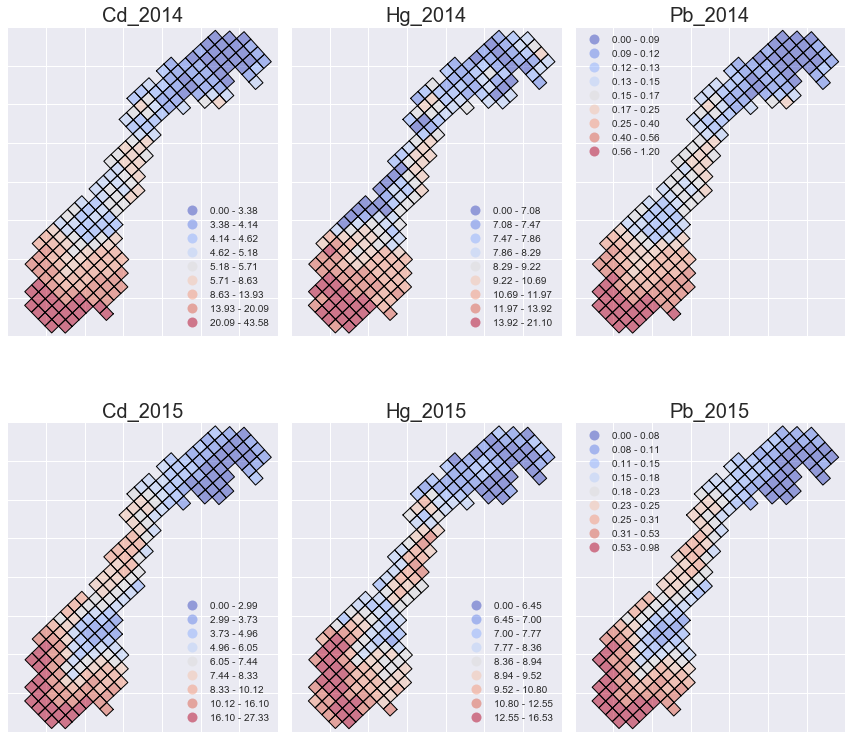

In [15]:
# Plot
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,12))
axes = axes.flatten()

# Loop over data
cols = ['cd_2014', 'hg_2014', 'pb_2014', 'cd_2015', 'hg_2015', 'pb_2015']

for idx, col in enumerate(cols):   
    # Choropleth
    gdf.plot(ax=axes[idx], column=col, cmap='coolwarm',
             scheme='QUANTILES', k=9,  edgecolor='black',
             alpha=0.5, legend=True)

    axes[idx].set_aspect('equal')
    axes[idx].xaxis.set_ticklabels([])
    axes[idx].yaxis.set_ticklabels([])
    axes[idx].set_title(col.capitalize(), fontsize=20)
    
plt.tight_layout()

In [16]:
# User input
par = 'pb_2015'
unit = 'kg/km2/yr'

# Choropleth map
map2 = nivapy.spatial.choropleth_from_gdf(gdf, par, geom='geometry', 
                                          tiles='Stamen Terrain', fill_color='YlOrRd', 
                                          fill_opacity=0.4, line_opacity=1,
                                          legend_name='%s deposition (%s)' % (par, unit))
map2

Note that on the maps above, Pb is in kg/km2/yr, while Cd and Hg are in g/km2/yr.

### 2.2. Atmospheric inputs by regine

The next step is to intersect the deposition data with the regine catchments to estimate atmospheric inputs of metals for each catchment. With the MSC-E data, I can only do this for three metals in two years, but at least this will allow me to guage whether there is a clear relationship between deposition and river fluxes.

In [17]:
# Read regine shapefile
reg_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Data\gis\shapefiles\RegMinsteF.shp')
reg_gdf = gpd.read_file(reg_shp)

# Get cols of interest
reg_gdf = reg_gdf[['geometry', 'VASSDRAGNR']]
reg_gdf.columns = ['geometry', 'regine']

# Convert crs to UTM Z33
reg_gdf = reg_gdf.to_crs(epsg='32633')

In [18]:
def spatial_overlays(df1, df2, how='intersection'):
    """Hugely improves performance compared to gpd.overlay(df1, df2, how='intersection').
       An improved version should eventually be available within Geopandas itself.
       
       From here:
           https://github.com/geopandas/geopandas/issues/400
    """
    import geopandas as gpd
    import pandas as pd
    
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['histreg'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, 
                            suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: 
                                            (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), 
                                            axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('histreg')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        return dfinter
    
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                                  [x.geometry]+list(df2.iloc[x.histreg].geometry)), 
                                 axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'histreg', new_g], axis=1, inplace=True)
        return df1

In [19]:
# Intersection
int_gdf = spatial_overlays(reg_gdf, gdf, how='intersection')

# Save
out_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\Raw_Datasets\EMEP\regine_atmos_dep_intersection.shp')
int_gdf.to_file(out_shp)

In [20]:
# Areas for each intersected polygon
int_gdf['area_km2'] = int_gdf['geometry'].area / 1.E6

# Loads per regine part
for col in cols:
    int_gdf['%s_ld' % col] = int_gdf[col] * int_gdf['area_km2'] # g for Cd and Hg
                                                                # kg for Pb

# Sum regine areas in intersected file
agg_df = pd.DataFrame(int_gdf).groupby('regine').sum()

# Convert back to avg dep rates per regine
for col in cols:
    agg_df[col] = agg_df['%s_ld' % col] / agg_df['area_km2']

# Tidy
agg_df.reset_index(inplace=True)

# Join back to regine gdf
reg_gdf = reg_gdf.merge(agg_df, on='regine', how='left')

# Get regine areas in original shp
reg_gdf['area_km2'] = reg_gdf['geometry'].area / 1.E6

# Loads per regine 
for col in cols:
    # Get par
    par = col.split('_')[0]
    
    # Calc loads, converting to tonnes
    if par == 'pb': # kgs
        reg_gdf['%s_ld' % col] = reg_gdf[col] * reg_gdf['area_km2'] / 1000.
        
    else: # g
        reg_gdf['%s_ld' % col] = reg_gdf[col] * reg_gdf['area_km2'] / 1.E6

# Get cols of interest
reg_gdf = reg_gdf[['geometry', 'regine', 'area_km2', 'cd_2014_ld', 'hg_2014_ld', 
                   'pb_2014_ld', 'cd_2015_ld', 'hg_2015_ld', 'pb_2015_ld']]

# Save
out_shp = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\Metals\Raw_Datasets\EMEP\regine_atmos_dep.shp')
reg_gdf.to_file(out_shp)

reg_gdf.head()

,geometry,regine,area_km2,cd_2014_ld,hg_2014_ld,pb_2014_ld,cd_2015_ld,hg_2015_ld,pb_2015_ld
0,"POLYGON ((-38501.56000000006 6783604.03, -3780...",067.62,50.522164,0.000709,0.000624,0.020547,0.000902,0.000639,0.028071
1,"POLYGON ((127984.12 6573462.089999999, 128145....",019.F211,66.024889,0.001760,0.001128,0.047523,0.001059,0.000896,0.036137
2,"POLYGON ((87091.19 6815443.639999999, 87094.91...",077.1E,3.419020,0.000026,0.000034,0.000739,0.000025,0.000036,0.000817
3,"POLYGON ((630710.87 7690571.19, 630714.57 7690...",196.2A2A,4.594701,0.000020,0.000034,0.000583,0.000024,0.000031,0.000714
4,"POLYGON ((424201.31 7329879.499999999, 424075....",152.2D2B3,1.336261,0.000009,0.000013,0.000237,0.000012,0.000014,0.000341


### 2.3. Accumulate point and atmospheric inputs

The code below combines the point and atmospheric inputs and accumulates them over the catchment network (assuming no retention).

In [21]:
# Data of interest
st_yr, end_yr = 2014, 2015

par_list = ['Cd', 'Hg', 'Pb']

In [22]:
# Convert gdf to df
reg_df = pd.DataFrame(reg_gdf[['regine', 'area_km2', 'cd_2014_ld', 'hg_2014_ld', 
                               'pb_2014_ld', 'cd_2015_ld', 'hg_2015_ld', 'pb_2015_ld']])

# Container for results
data_dict = defaultdict(list)

# Loop over years
for year in range(st_yr, end_yr+1):
    # Group point metal inputs by regine 
    sql = ("SELECT a.regine, "
           "  b.name, "
           "  b.unit, "
           "  SUM(c.value * d.factor) as value "
           "FROM RESA2.RID_PUNKTKILDER a, "
           "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
           "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
           "RESA2.RID_PUNKTKILDER_INP_OUTP d "
           "WHERE a.anlegg_nr = c.anlegg_nr "
           "AND d.in_pid = c.inp_par_id "
           "AND d.out_pid = b.out_pid "
           "AND c.year = %s "
           "GROUP BY a.regine, b.name, b.unit "
           "ORDER BY a.regine" % year)
    df = pd.read_sql(sql, engine)
    
    # Get cols of interest
    df = df[df['name'].isin(par_list)]

    # Tidy
    df['par'] = df['name'] + '_' + df['unit']
    del df['name'], df['unit']

    # Pivot
    df = df.pivot(index='regine', columns='par', values='value')
    df.reset_index(inplace=True)
    
    # Join to network data and tidy
    df = pd.merge(net_df, df, how='left', on='regine')
    
    # Join atmospheric data
    df = pd.merge(df, reg_df, how='left', on='regine')
    df.fillna(0, inplace=True)
    
    # Sum point and atmos
    for par in par_list:
        df['%s_tonn' % par] = df['%s_tonn' % par] + df['%s_%s_ld' % (par.lower(), year)]
    
    # Get cols of interest
    df = df[['regine',] + ['%s_tonn' % i for i in par_list]]
    df.index = df['regine']
    del df['regine']
    
    # Update network properties
    for idx, row in df.iterrows():
        g.node[idx]['local'] = row.to_dict()
    
    # Accumulate downstream
    # Process nodes in topo order from headwaters down
    for nd in nx.topological_sort(g)[:-1]:
        # Get catchments directly upstream
        preds = g.predecessors(nd)

        if len(preds) > 0:
            # Accumulate total input from upstream
            tot_dict = defaultdict(int) # Defaults to 0

            # Loop over upstream catchments            
            for pred in preds:                
                # Loop over quantities of interest
                for col in df.columns:
                    tot_dict[col] += g.node[pred]['accum'][col]              

            # Assign outputs  
            for col in df.columns:
                g.node[nd]['accum'][col] = g.node[nd]['local'][col] + tot_dict[col]

        else:
            # No upstream inputs
            for col in df.columns:
                g.node[nd]['accum'][col] = g.node[nd]['local'][col]
    
    # Get accumulated loads for RID-155 rivers    
    for idx, row in stn_df.iterrows():
        data_dict['station_id'].append(row['station_id'])
        data_dict['year'].append(year)
        for col in df.columns:
            data_dict[col].append(g.node[row['nve_vassdrag_nr']]['accum'][col])

# Build df
mod_df = pd.DataFrame(data_dict)

# Reorder cols and remove units
mod_df.set_index(['station_id', 'year'], inplace=True)
mod_df.columns = [i.split('_')[0] for i in mod_df.columns]
mod_df.reset_index(inplace=True)

mod_df.head()

,station_id,year,Cd,Hg,Pb
0,29615,2014,0.073559,0.071976,2.055466
1,29821,2014,0.017353,0.016353,0.496281
2,29783,2014,0.002863,0.001441,0.072592
3,29613,2014,0.159300,0.148916,4.529632
4,29614,2014,0.095205,0.065338,2.766113


### 2.4. Compare to observed

The plots below show how the summed point and atmospheric deposition data compare to the observed loads (assuming everything is transported to the coast).

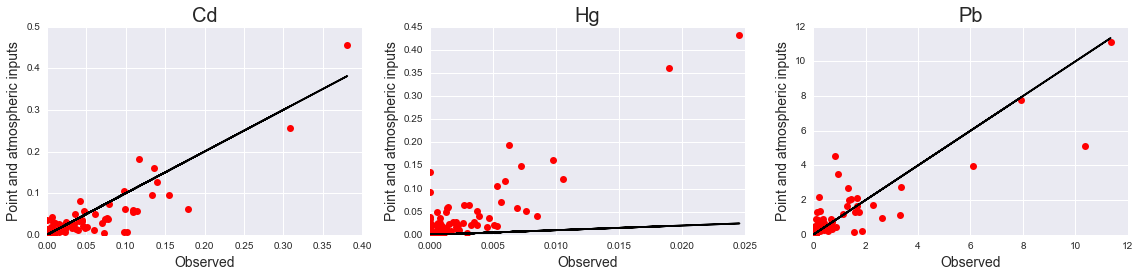

In [23]:
# Join mod and obs
df = pd.merge(mod_df, obs_df, how='left', on=['station_id', 'year'],
              suffixes=['_mod', '_obs'])

# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
axes = axes.flatten()

for idx, col in enumerate(par_list):
    axes[idx].plot(df['%s_obs' % col], df['%s_mod' % col], 'ro')
    axes[idx].plot(df['%s_obs' % col], df['%s_obs' % col], 'k-')
    axes[idx].set_title(col, fontsize=20)
    axes[idx].set_xlabel('Observed', fontsize=14)
    axes[idx].set_ylabel('Point and atmospheric inputs', fontsize=14)

plt.tight_layout()
plt.show()

Incorporating atmospheric deposition clearly gives much better results than just allowing for point inputs (compare with the plots in section 1.3). For Cd and Pb, we actually get reasonable results by just assuming all inputs make it to the sea. For Hg, however, this approach **dramatically overestimates** fluxes, implying that either (i) the MSC-E simulations substantially over-predict Hg deposition, or (ii) much more Hg is retained in the freshwater/terrestrial environment than for Cd or Pb. Note also that the Hg concentrations measured in rivers as part of the RID programme are usually very low (often below the LOD), so our load estimates for Hg are poorly constrained and therefore difficult assess.

### 2.5. Summary of atmospheric deposition

 * Combining the MSC-E simulations with point discharge estimates gives substantially improved flux estimates compared to using point values alone (even ignoring any catchment retention) <br><br>
 
 * Results for Cd and Pb look especially promising; for Hg, this approach looks like it would substantially overestimate fluxes <br><br>
 
 * The data imply that **Hg might be more strongly retained in catchments than Cd or Pb. Is there a physical/scientific basis for why this might be?** <br><br>
 
 * MSC-E only proivde data for 2014 and 2015 for three metals: Hg, Cd and Pb. I assume these datasets will be updated each year, but probably not in time for RID reporting (the 2016 data are not yet available, for example). <br><br>
 
 * MSC-E therefore provides a good starting point, but we need to find some way of generalising to other metals. This may not be straightforward, as the plots above suggest it is not reasonable to treat all metals the same way.